<a href="https://colab.research.google.com/github/greypirate/Stock-Predictor/blob/main/Predictor_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Stock_Price_Predictor'
%cd $project_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Stock_Price_Predictor


#Imports

In [ ]:
# Imports
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
import datetime as dt
import random
import os

# Imports for model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Initialize Keras
keras = tf.keras

#Loading and Processing Data

In [ ]:
# Stock info
ticker = 'AMZN'

start = dt.datetime(2010,1,1)
end = dt.datetime(2023,5,31)

In [ ]:
# Load stock data
yf.pdr_override()
data = pdr.data.get_data_yahoo(ticker,start,end)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Pre-process data

'''
Adds column for open and close price difference
@return Dataset with added 'Difference' column
'''
def create_remove_columns(data):
  # Create change column for the difference between open and close price
  data = pd.DataFrame.copy(data)
  data['Difference'] = data['Open']-data['Close'].shift(1)
  data['Difference'].fillna(0, inplace=True)
  data.insert(0,'Difference', data.pop('Difference'))
  return data

In [ ]:
'''
Normalizes data
@return Normalized dataset + scaler and decoder functions
'''
def normalize_data(data, scaler=None):
  # Create copy of data
  stock_data = pd.DataFrame.copy(data)

  # Substract the open amount from all columns except first and last ("Difference" and "Volume")
  stock_data.iloc[:, 1:-1] = stock_data.iloc[:,1:-1] - stock_data['Open'].values[:, np.newaxis]
  stock_data.pop('Open')

  # If scaler does not exist, create one
  if scaler is None:
    values = np.abs(stock_data.values)
    max_value = np.max(values[:,:-1])
    max_volume = np.max(values[:,-1])
    
    # Normalizes data
    def scaler(d):
      data = pd.DataFrame.copy(d)
      print('max_value: ', max_value)
      print('max_volume: ', max_volume)

      # Value and volume can very greatly daily so dividng by the max in each column helps to normalize the data
      data.iloc[:, :-1] = data.iloc[:,:-1].apply(lambda x: x/max_value)
      data.iloc[:, -1] = data.iloc[:,-1].apply(lambda x: x/max_volume)
      return data
    
    # Reverses normalization
    def decoder(values):
      decoded_values = values * max_value
      return decoded_values
  
  else:
    decoder = None
  
  # New normalized data
  normalized_data = scaler(stock_data)
  
  return normalized_data, scaler, decoder

In [ ]:
'''
Prepares normalized data for training by splitting into two lists:
- One containing the data to make predictions from (previous day's price)
- One containing the correct labels (actual current price)

@returns Numpy arrays containing training data and labels
'''
def create_training_data(normalized_data):
  # Number of training days
  num_prediction_days = 730
  
  x_data = []
  y_data = []
  print('normalized_data shape:')
  print(normalized_data.shape)
  
  # Iterate through data
  for i in range(num_prediction_days, len(normalized_data)):
    x_data.append(normalized_data.iloc[i-num_prediction_days:i])
    y_data.append(normalized_data.iloc[i-num_prediction_days+1:i+1,0:4])
  
  return np.array(x_data), np.array(y_data)

In [ ]:
# Pre-processing function
def preprocess(data, scaler=None):
  new_data = create_remove_columns(data)
  norm_data, scaler, decoder = normalize_data(new_data, scaler=scaler)
  x_data, y_data = create_training_data(norm_data)

  return x_data, y_data, scaler, decoder

Applying preprocessing to data

In [ ]:
x_data, y_data, scaler, decoder = preprocess(data)

print(x_data.shape)
print(y_data.shape)

max_value:  16.761001586914062
max_volume:  848422000.0
normalized_data shape:
(3374, 6)
(2644, 730, 6)
(2644, 730, 4)


#Model

In [ ]:
'''
@return A sequential model with 3 LTSM layers and one dense layer
'''
def create_model():
  model = Sequential()
  model.add(LSTM(units=1024, return_sequences=True, input_shape=(None,x_data.shape[-1],)))
  model.add(LSTM(units=1024, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=1024, return_sequences=True))
  # 4 outputs: open price, max, min, close price
  model.add(Dense(4))

  return model

Create model

In [ ]:
model = create_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, None, 1024)        4222976   
                                                                 
 lstm_4 (LSTM)               (None, None, 1024)        8392704   
                                                                 
 dropout_1 (Dropout)         (None, None, 1024)        0         
                                                                 
 lstm_5 (LSTM)               (None, None, 1024)        8392704   
                                                                 
 dense_1 (Dense)             (None, None, 4)           4100      
                                                                 
Total params: 21,012,484
Trainable params: 21,012,484
Non-trainable params: 0
_________________________________________________________________
None


Compile model

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])

#Training The Model

In [ ]:
print(x_data.shape)
print(y_data.shape)

(2644, 730, 6)
(2644, 730, 4)


In [ ]:
n = x_data.shape[0]
random.seed(1)
# Indexes for training data
train_indexes = random.sample(range(n), int(n * 0.8))
# Indexes for valuation data
val_indexes = [x for x in range(n) if x not in train_indexes]
print(len(train_indexes))
print(len(val_indexes))

2115
529


In [ ]:
# Training data
x_train = x_data[train_indexes,:]
y_train = y_data[train_indexes,:]

# Valuation data
x_val = x_data[val_indexes,:]
y_val = y_data[val_indexes,:]

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(2115, 730, 6)
(2115, 730, 4)
(529, 730, 6)
(529, 730, 4)


In [ ]:
train_model = True

if train_model:
  # Directory where the checkpoints will be saved
  checkpoint_dir = './training_checkpoints_'+dt.datetime.now().strftime("%Y%m%d%H%M%S")
  # Name of checkpoint files
  checkpoint_path = os.path.join(checkpoint_dir, "checkpoint")
  checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path,
      save_weights_only=True,
      monitor="loss",
      mode="min",
      save_best_only=True)

history = model.fit(x=x_train,y=y_train,
                    epochs=10,
                    batch_size=32,
                    callbacks=[checkpoint_callback],
                    validation_data=(x_val,y_val))

Epoch 1/10
67/67 [==============================] - 102s 1s/step - loss: 0.0036 - accuracy: 0.7384 - val_loss: 0.0034 - val_accuracy: 0.7510
Epoch 2/10
67/67 [==============================] - 86s 1s/step - loss: 0.0033 - accuracy: 0.7668 - val_loss: 0.0034 - val_accuracy: 0.7672
Epoch 3/10
67/67 [==============================] - 86s 1s/step - loss: 0.0033 - accuracy: 0.7611 - val_loss: 0.0033 - val_accuracy: 0.7785
Epoch 4/10
67/67 [==============================] - 86s 1s/step - loss: 0.0033 - accuracy: 0.7615 - val_loss: 0.0033 - val_accuracy: 0.7236
Epoch 5/10
67/67 [==============================] - 86s 1s/step - loss: 0.0033 - accuracy: 0.7608 - val_loss: 0.0033 - val_accuracy: 0.7314
Epoch 6/10
67/67 [==============================] - 82s 1s/step - loss: 0.0033 - accuracy: 0.7559 - val_loss: 0.0034 - val_accuracy: 0.7598
Epoch 7/10
67/67 [==============================] - 85s 1s/step - loss: 0.0033 - accuracy: 0.7568 - val_loss: 0.0033 - val_accuracy: 0.7651
Epoch 8/10
67/67 [=

Save model

In [ ]:
!mkdir -p saved_model
model.save('saved_model/predictor_model')

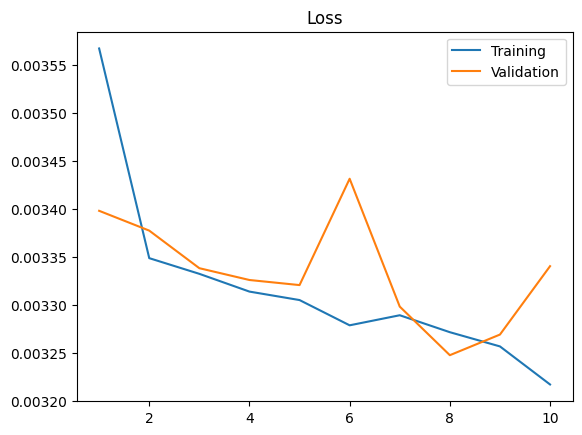

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(1)
plt.plot(range(1, len(train_loss)+1), train_loss, label='Training')
plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation')
plt.legend()
plt.title('Loss')
plt.show()

#Testing The Model

In [ ]:
weights_filepath = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(weights_filepath)

In [ ]:
ticker = 'AMZN'

test_start = dt.datetime(2015,1,1)
test_end = dt.datetime(2023,6,9)

yf.pdr_override()
test_data = pdr.data.get_data_yahoo(ticker,test_start,test_end)

[*********************100%***********************]  1 of 1 completed


In [ ]:
test_x, test_y, scaler, decoder = preprocess(test_data)

print(test_x.shape)
print(test_y.shape)

max_value:  16.761001586914062
max_volume:  477122000.0
normalized_data shape:
(2123, 6)
(1393, 730, 6)
(1393, 730, 4)


In [ ]:
predictions = model.predict(test_x)

44/44 [==============================] - 17s 380ms/step


In [ ]:
num_correct = 0
num_incorrect = 0
no_action = 0

for prediction, actual in zip(predictions[:],test_y[:]):
  compare = prediction[-1][3]*actual[-1][3]
  if compare > 0:
    num_correct += 1
  elif compare < 0:
    num_incorrect += 1
  else:
    no_action += 1

print(f"Num correct: {num_correct}")
print(f"Num incorrect: {num_incorrect}")
print(f"No action: {no_action}")
print(f"Accuracy = {(num_correct/len(predictions))*100}")

Num correct: 759
Num incorrect: 633
No action: 1
Accuracy = 54.486719310839916
